In [4]:
import json
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
from diffusers.image_processor import VaeImageProcessor



class DiffusionDataset(Dataset):
    def __init__(self, json_path):
        with open(json_path, 'r') as f:
            self.data = json.load(f)
        self.image_factor_x = 360 / 320    
        self.image_factor_y = 640 / 512
        self.transform = transforms.Compose([
            transforms.Resize((int(360/self.image_factor_y) , int(640/self.image_factor_x))),
            transforms.CenterCrop((320, 512)),
        ])
        self.image_processor = VaeImageProcessor(vae_scale_factor=8)

    def __len__(self):
        # Assuming each set of ground truths represents a separate sample
        return len(self.data['ground_truth'])

    def __getitem__(self, idx):
        # Processing ground truth images
        
        ground_truth_images = [self.transform(Image.open(path)) for path in self.data['ground_truth'][idx]]
        ground_truth_images = self.image_processor.preprocess(image = ground_truth_images, height = 320, width = 512)

        # prescan_images = [self.transform(Image.open(path)) for path in self.data['prescan_images'][idx]]
        # prescan_images = self.image_processor.preprocess(image = prescan_images, height = 320, width = 512)

        # Processing conditioning images set one (assuming RGB, 4 channels after conversion)
        conditioning_images_one = [self.transform(Image.open(path).convert("RGB")) for path in self.data['conditioning_images_one'][idx]]
        conditioning_images_one = self.image_processor.preprocess(image = conditioning_images_one, height = 320, width = 512)

        # Processing conditioning images set two (assuming grayscale, converted to RGB to match dimensions)
        # conditioning_images_two = [self.transform(Image.open(path)) for path in self.data['conditioning_images_two'][idx]]
        # conditioning_images_two = self.image_processor.preprocess(image = conditioning_images_two, height = 320, width = 512)
        
        # Concatenating condition one and two images along the channel dimension
        # conditioned_images = [torch.cat((img_one, img_two), dim=0) for img_one, img_two in zip(conditioning_images_one, conditioning_images_two)]

        # Processing reference images (single per scene, matched by index)
        # reference_image = self.transform(Image.open(self.data['ground_truth'][idx][0]))

        # Retrieving the corresponding caption
        caption = self.data['caption'][idx][0]
        reference_image = self.transform(Image.open(self.data['ground_truth'][idx][0]))

        

        return {
            "ground_truth": ground_truth_images,
            "conditioning": conditioning_images_one,
            "caption": caption,
            "reference_image": reference_image,
            # "prescan_images": prescan_images
        }

def collate_fn(batch):
    ground_truth = torch.stack([item['ground_truth'] for item in batch])
    conditioning = torch.stack([item['conditioning'] for item in batch])
    captions = [item['caption'] for item in batch]  # List of strings, no need to stack
    reference_images = [item['reference_image'] for item in batch]
    

    return {
        "ground_truth": ground_truth,
        "conditioning": conditioning,
        "caption": captions[0],
        "reference_image": reference_images[0],
    }

train_dataset = DiffusionDataset(json_path='/home/wisley/custom_diffusers_library/src/diffusers/jasper/jappie_seg.json')

train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    shuffle=True,
    collate_fn=collate_fn,
    batch_size=1,  # Or your preferred batch size
    num_workers=0,  # Adjust based on your setup
)

print(train_dataset.column_names)

AttributeError: 'DiffusionDataset' object has no attribute 'column_names'

In [20]:
from datasets import Dataset, Image
import json

# Load JSON to dict
with open('/home/wisley/custom_diffusers_library/src/diffusers/jasper/jappie_seg.json', 'r') as f:
    my_dict = json.load(f)
# remove the key and value "scene_name" from the dictionary
my_dict.pop("scene_name")

# flatten all the lists in the dictionary
for key in my_dict:
    if key != "scene_name":
        my_dict[key] = [item for sublist in my_dict[key] for item in sublist]
    
# repeat each caption 14 times
my_dict["caption"] = [item for sublist in my_dict["caption"] for item in [sublist]*14]

# Get only the first 14 elements of the dictionary
my_dict = {k: my_dict[k] for k in my_dict}
# my_dict = {
#     "train" : my_dict
# }
# Create a dataset from the dictionary
dataset_ = Dataset.from_dict(my_dict)


# Cast columns to Image data type
dataset_ = dataset_.cast_column("ground_truth", Image())
dataset_ = dataset_.cast_column("conditioning_images_one", Image())


# save to disk
dataset_.save_to_disk('/mnt/d/seg_dataset_full')


Saving the dataset (116/116 shards): 100%|██████████| 161294/161294 [1:15:50<00:00, 35.44 examples/s]


In [18]:
import diffusers
print(diffusers.__version__)

0.28.0.dev0


{'caption': 'A driving scene during the day, with clear weather in singapore-onenorth', 'conditioning_images_one': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=640x360 at 0x7F4078D2D520>, 'ground_truth': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=640x360 at 0x7F4078D2D850>}
(640, 360)


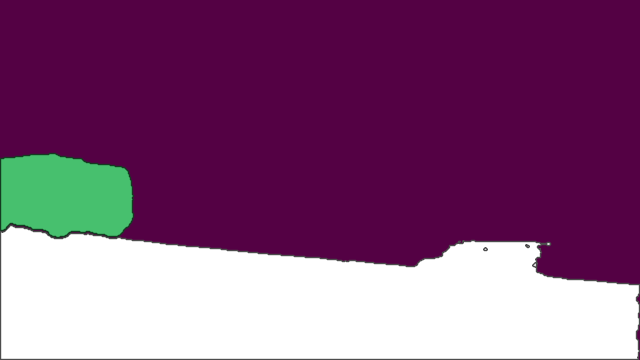

In [4]:
from datasets import Dataset, Image
import json

# Load the dataset 
dataset = Dataset.load_from_disk('/mnt/d/seg_dataset_full')

# Print the first example
print(dataset[0])

# show the first example
conditioning_images_one = dataset[0]["conditioning_images_one"]

# print the size
print(conditioning_images_one.size)

conditioning_images_one.show()

In [5]:
len(dataset)

161294